In [1]:
!pip install unimod_mapper

In [2]:
import pandas as pd
import numpy as np
from utils import tryptic_digest_pyopenms
import itertools
from tqdm import tqdm

# Proteomics imports
from unimod_mapper import UnimodMapper
from pyteomics.mass.mass import std_aa_mass
from collections import defaultdict

from itertools import combinations
from matplotlib import pyplot as plt

In [3]:
def calculate_possibilities(possibilities,max_mods=3):
    N = len(possibilities)  # Total number of positions
    total = 0

    # Iterate over the number of positions that can vary (0 to 3)
    for k in range(0, max_mods+1):
        # Generate all combinations of positions that can vary
        for varying_positions in combinations(range(N), k):
            # Calculate the product of possibilities for the chosen positions
            product = 1
            for pos in varying_positions:
                product *= possibilities[pos]
            # Add this product to the total sum
            total += product

    return total


def modification_list_to_dict(all_amino_acids, modifications_search_space):
    modification_dict = defaultdict(list)
    for modification, amino_acids in modifications_search_space:
        for aa in amino_acids:
            modification_dict[aa].append(modification)

    for aa in all_amino_acids:
        modification_dict[aa].insert(0, "")

    modification_dict = dict(modification_dict)
    return modification_dict


def apply_modifications(
    peptides, modifications, charges=[2, 3, 4, 5], max_var_mods=3, # max_len=30, min_len=7
):
    unique_peptides = set([p[-1] for p in peptides])
    tot_num = 0
    tot_num_fragments = 0

    for idx, peptide_seq in enumerate(unique_peptides):
        #if len(peptide_seq) > max_len or len(peptide_seq) < min_len:
        #    continue
        all_pos = [len(modifications[aa]) - 1 for aa in peptide_seq]
        poss = calculate_possibilities(all_pos, max_mods=max_var_mods) * len(charges)
        tot_num += poss
        tot_num_fragments += poss * len(peptide_seq) * 2

    return tot_num

In [4]:
import pandas as pd
from itertools import product

# Your modification data
modifications_search_space = [
    ("[Oxidation]", ["M"]),  # , "P"
    ("[OxidationP]", ["P"]),  # , "P"
    ("[Carbamidomethyl]", ["C"]),
    ("[Alkyl]", ["C"]),
    ("[DeamidationN]", ["N"]),
    ("[DeamidationQ]", ["Q"]),
    ("[PhosphorylationS]", ["S"]),
    ("[PhosphorylationT]", ["T"]),
    ("[PhosphorylationY]", ["Y"]),
    ("[Nitrosyl]", ["C"]),
    ("[OxidationC]", ["C"]),
    ("[Methyl]", ["K"]),
    ("[MethylR]", ["R"]),
    ("[Dimethyl]", ["K"]),
    ("[DimethylR]", ["R"]),
    ("[Trimethyl]", ["K"]),
    ("[CitrullinationR]", ["R"]),
    ("[Propionyl]", ["K"]),
    ("[Butyryl]", ["K"]),
    ("[Malonyl]", ["K"]),
    ("[Succinyl]", ["K"]),
    ("[Glutarylation]", ["K"]),
    ("[Crotonyl]", ["K"]),
    ("[Hydroxyisobutyryl]", ["K"]),
    ("[Biotin]", ["K"]),
    ("[GG]", ["K"]),
    ("[NitroY]", ["Y"]),
]


charge_min_range = range(1, 3)
charge_max_range = [5] #range(2, 6)
maximum_length_range = [35] #range(30, 50, 2)
max_var_mods_range = [3] #range(1, 4)
missed_cleavages = [2] #range(0,4)
num_var_mods = range(0, len(modifications_search_space))

combinations_df = product(
    charge_min_range,
    charge_max_range,
    maximum_length_range,
    max_var_mods_range,
    missed_cleavages,
    num_var_mods,
)

df = pd.DataFrame(
    combinations_df,
    columns=[
        "charge_min",
        "charge_max",
        "maximum_length",
        "max_var_mods",
        "missed_cleavages",
        "num_var_mods",
    ],
)

In [5]:
fasta_analyze = "fasta/human_22032024.fasta"

peptides = tryptic_digest_pyopenms(
    fasta_analyze,
    min_len=6,
    max_len=35,
    missed_cleavages=int(2),
)

In [6]:
fasta_analyze = "fasta/human_22032024.fasta"

# Define all standard amino acids
all_amino_acids = set(
    "ABCDEFGHIKLMNPQRSTUVWXY"
)  # 20 standard amino acids + additional ones that can be in the fasta, they are ignored if they are not in there

search_space_list = []
for idx,r in tqdm(df.iterrows()):
    print(idx,r)
    i = r["num_var_mods"]
    # Read peptides from fasta using a tryptic digest function
    peptides = tryptic_digest_pyopenms(
        fasta_analyze,
        min_len=6,
        max_len=r["maximum_length"],
        missed_cleavages=int(r["missed_cleavages"]),
    )

    modification_dict = modification_list_to_dict(
        all_amino_acids, modifications_search_space[0:i+1]
    )

    # Apply modifications to peptides
    all_peptidoforms = apply_modifications(
        peptides,
        modification_dict,
        charges=list(range(r["charge_min"], r["charge_max"])),
        max_var_mods=r["max_var_mods"],
    )
    print(f"Total number of unique peptidoforms: {all_peptidoforms}")
    search_space_list.append(all_peptidoforms)
    
df["search_space"] = search_space_list
df.to_csv("data/human_searchpace.csv")

0it [00:00, ?it/s]

0 charge_min           1
charge_max           5
maximum_length      35
max_var_mods         3
missed_cleavages     2
num_var_mods         0
Name: 0, dtype: int64


0it [00:02, ?it/s]


KeyboardInterrupt: 

In [7]:
df = pd.read_csv("data/human_searchpace.csv")

In [8]:
sub_df_search_space = df[df["charge_min"] == 1]

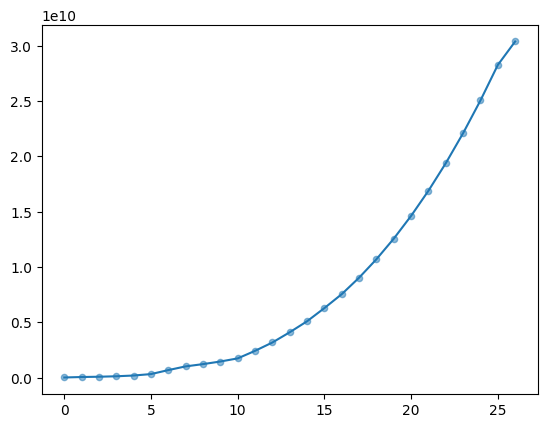

In [9]:
plt.scatter(sub_df_search_space["num_var_mods"], sub_df_search_space["search_space"],s=20,alpha=0.5)
plt.plot(sub_df_search_space["num_var_mods"], sub_df_search_space["search_space"])
plt.show()
# plt.scatter(
#    sub_df_search_space["num_var_mods"],
#    sub_df_search_space["search_space"]
#    * (sum([len(p[-1]) for p in peptides]) / len(peptides)),
# )

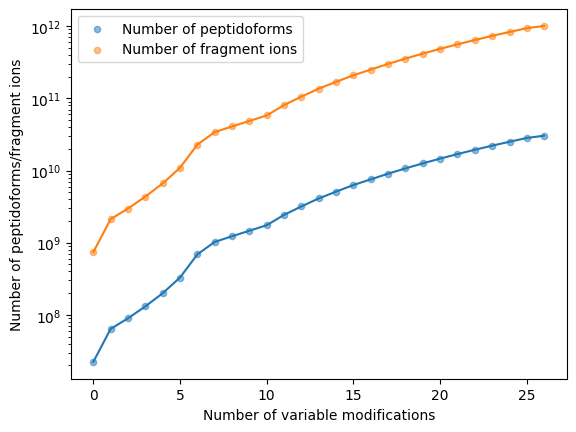

In [10]:
plt.scatter(
    sub_df_search_space["num_var_mods"],
    sub_df_search_space["search_space"],
    s=20,
    alpha=0.5,
    label="Number of peptidoforms",
)
plt.plot(sub_df_search_space["num_var_mods"], sub_df_search_space["search_space"])

factor_fragments = ((sum([len(p[-1]) for p in peptides]) / len(peptides))) * 2

plt.scatter(
    sub_df_search_space["num_var_mods"],
    sub_df_search_space["search_space"] * factor_fragments,
    s=20,
    alpha=0.5,
    label="Number of fragment ions",
)

plt.plot(
    sub_df_search_space["num_var_mods"],
    sub_df_search_space["search_space"] * factor_fragments,
)

ax = plt.gca()
ax.set_yscale("log")

plt.xlabel("Number of variable modifications")
plt.ylabel("Number of peptidoforms/fragment ions")

plt.legend()
plt.savefig("img/peptidoforms_num_fragments.svg")
plt.show()

In [11]:
sub_df_search_space

,charge_min,charge_max,maximum_length,max_var_mods,missed_cleavages,num_var_mods,search_space
0,1,5,35,3,2,0,22287368
1,1,5,35,3,2,1,63904568
2,1,5,35,3,2,2,89604440
3,1,5,35,3,2,3,130990944
4,1,5,35,3,2,4,199372532
5,1,5,35,3,2,5,329032448
6,1,5,35,3,2,6,689519328
7,1,5,35,3,2,7,1024408924
8,1,5,35,3,2,8,1228708580
9,1,5,35,3,2,9,1464423316
